# Model with PyTorch

In [6]:
from functions import *

In [7]:
import os
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
# from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
import string
import matplotlib.pyplot as plt

### create a class for the dataset

In [8]:
# Chargement des données
dataset = CaptchaDataset(file_path="data/6_CHARACTERS", size_image=(75, 250, 1), ncharacter_per_image=6, ncharacter_total=36)

train_size = len(dataset) - 11600
test_size = 11600
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# First model

### create a model

In [9]:
# Création du modèle
model_v1 = CaptchaModel(size_image=(75, 250, 1), n_characters_per_image=6, n_characters_total=36, dropout_val=0.8)
criterion = nn.BCELoss()
optimizer = optim.Adam(model_v1.parameters(), lr=0.001)

### train the model

In [10]:
# Listes pour stocker les pertes
train_losses = []
val_losses = []

# Entraînement
num_epochs = 30
for epoch in range(num_epochs):
    model_v1.train()
    running_loss = 0.0
    for images, labels in train_loader:
        # put the image and the label on the gpu
        images = images.to(device)
        label  = labels.to(device)
         
        optimizer.zero_grad()
        outputs = model_v1(images)
        loss = sum(criterion(output, label) for output, label in zip(outputs, labels.permute(1, 0, 2)))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss / len(train_loader))

    # Validation
    model_v1.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model_v1(images)
            loss = sum(criterion(output, label) for output, label in zip(outputs, labels.permute(1, 0, 2)))
            val_loss += loss.item()
    val_losses.append(val_loss / len(test_loader))
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}')

NameError: name 'device' is not defined

In [ ]:
torch.save(model_v1, "model/model_full_v1.pth")

### plot the loss function

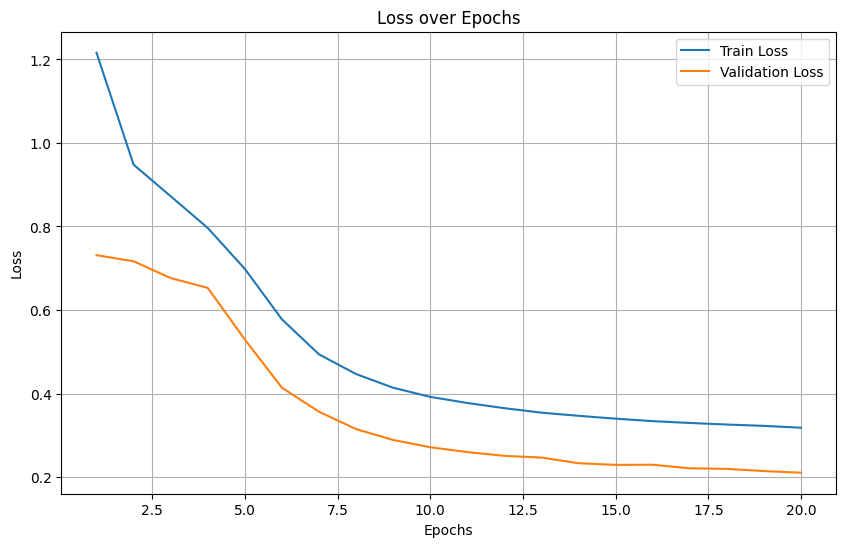

In [11]:
# Tracé des pertes
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
model_v1 = torch.load("model/model_full_v1.pth")
model_v1.eval()

C:\Users\Nasir\AppData\Local\Temp\ipykernel_19656\1731206599.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_v1 = torch.load("model_full_v1.pth")


CaptchaModel(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_layers): ModuleList(
    (0-5): 6 x Sequential(
      (0): Linear(in_features=8928, out_features=64, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.8, inplace=False)
      (3): Linear(in_features=64, out_features=36, bias=True)
      (4): Sigmoid()
    )
  )
)

In [13]:
summary(model_v1, (1, 75, 250))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 16, 75, 250]         160
├─MaxPool2d: 1-2                         [-1, 16, 37, 125]         --
├─Conv2d: 1-3                            [-1, 32, 37, 125]         4,640
├─MaxPool2d: 1-4                         [-1, 32, 18, 62]          --
├─Conv2d: 1-5                            [-1, 32, 18, 62]          9,248
├─MaxPool2d: 1-6                         [-1, 32, 9, 31]           --
├─BatchNorm2d: 1-7                       [-1, 32, 9, 31]           64
├─ModuleList: 1                          []                        --
|    └─Sequential: 2-1                   [-1, 36]                  --
|    |    └─Linear: 3-1                  [-1, 64]                  571,456
|    |    └─ReLU: 3-2                    [-1, 64]                  --
|    |    └─Dropout: 3-3                 [-1, 64]                  --
|    |    └─Linear: 3-4                  [-1, 36]                  2,340


Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 16, 75, 250]         160
├─MaxPool2d: 1-2                         [-1, 16, 37, 125]         --
├─Conv2d: 1-3                            [-1, 32, 37, 125]         4,640
├─MaxPool2d: 1-4                         [-1, 32, 18, 62]          --
├─Conv2d: 1-5                            [-1, 32, 18, 62]          9,248
├─MaxPool2d: 1-6                         [-1, 32, 9, 31]           --
├─BatchNorm2d: 1-7                       [-1, 32, 9, 31]           64
├─ModuleList: 1                          []                        --
|    └─Sequential: 2-1                   [-1, 36]                  --
|    |    └─Linear: 3-1                  [-1, 64]                  571,456
|    |    └─ReLU: 3-2                    [-1, 64]                  --
|    |    └─Dropout: 3-3                 [-1, 64]                  --
|    |    └─Linear: 3-4                  [-1, 36]                  2,340


###  test the model on the test dataset

In [15]:
characters = string.ascii_uppercase + string.digits
model_v1.eval()
truepos = 0
count_img = 0
for images, labels in test_dataset:
    # print(images.shape)
    # print(labels.shape)
    # print(images)
    # print(model(images.unsqueeze(0)))
    prediction = predict_1(model_v1, images)
    labels = [characters[torch.argmax(la).item()] for la in labels]
    if sum(p == g for p, g in zip(prediction, labels)) != 6:
        count_img += 1
    #     print(prediction)
    #     print(labels)
    truepos += sum(p == g for p, g in zip(prediction, labels))
    

Accuracy = truepos/(len(test_dataset)*6)
Accuracy_v1 = (len(test_dataset)-count_img)/len(test_dataset)

### Result

In [16]:
print(f"l'accuracy sur les caractères est de {Accuracy}")
print(f"le nombre d'image qui ont au moins un caractère incorrect est de {count_img}") #count_img
print(f"l'autre accuracy sur les images est de {Accuracy_v1}") 

l'accuracy sur les caractères est de 0.8560632183908046
le nombre d'image qui ont au moins un caractère incorrect est de 4477
l'autre accuracy sur les images est de 0.6140517241379311


# Second Model

### create a model

In [17]:
# Création du modèle
model_v2 = CaptchaModel(size_image=(75, 250, 1), n_characters_per_image=6, n_characters_total=36, dropout_val=0.3)
criterion = nn.BCELoss()
optimizer = optim.Adam(model_v2.parameters(), lr=0.001)

In [18]:
# Listes pour stocker les pertes
train_losses = []
val_losses = []

# Entraînement
num_epochs = 20
for epoch in range(num_epochs):
    model_v2.train()
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model_v2(images)
        loss = sum(criterion(output, label) for output, label in zip(outputs, labels.permute(1, 0, 2)))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss / len(train_loader))

    # Validation
    model_v2.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model_v2(images)
            loss = sum(criterion(output, label) for output, label in zip(outputs, labels.permute(1, 0, 2)))
            val_loss += loss.item()
    val_losses.append(val_loss / len(test_loader))
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}')

Epoch [1/20], Train Loss: 0.4862, Val Loss: 0.1629
Epoch [2/20], Train Loss: 0.1497, Val Loss: 0.0938
Epoch [3/20], Train Loss: 0.0888, Val Loss: 0.0750
Epoch [4/20], Train Loss: 0.0628, Val Loss: 0.0765
Epoch [5/20], Train Loss: 0.0481, Val Loss: 0.0770
Epoch [6/20], Train Loss: 0.0396, Val Loss: 0.0716
Epoch [7/20], Train Loss: 0.0354, Val Loss: 0.0679
Epoch [8/20], Train Loss: 0.0311, Val Loss: 0.0683
Epoch [9/20], Train Loss: 0.0284, Val Loss: 0.0677
Epoch [10/20], Train Loss: 0.0257, Val Loss: 0.0788
Epoch [11/20], Train Loss: 0.0236, Val Loss: 0.0753
Epoch [12/20], Train Loss: 0.0227, Val Loss: 0.0963
Epoch [13/20], Train Loss: 0.0216, Val Loss: 0.0795
Epoch [14/20], Train Loss: 0.0200, Val Loss: 0.0754
Epoch [15/20], Train Loss: 0.0183, Val Loss: 0.0804
Epoch [16/20], Train Loss: 0.0185, Val Loss: 0.0937
Epoch [17/20], Train Loss: 0.0174, Val Loss: 0.0798
Epoch [18/20], Train Loss: 0.0162, Val Loss: 0.0855
Epoch [19/20], Train Loss: 0.0156, Val Loss: 0.0992
Epoch [20/20], Train 

In [ ]:
torch.save(model_v2, "model/model_full_v2.pth")

### plot the loss function

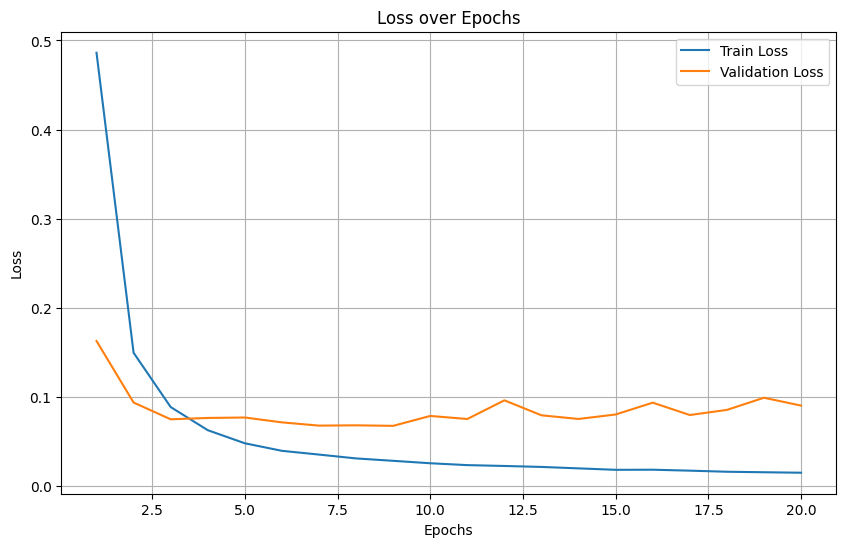

In [20]:
# Tracé des pertes
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
model_v2 = torch.load("model/model_full_v2.pth")
model_v2.eval()

C:\Users\Nasir\AppData\Local\Temp\ipykernel_19656\3639142723.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_v2 = torch.load("model_full_v2.pth")


CaptchaModel(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_layers): ModuleList(
    (0-5): 6 x Sequential(
      (0): Linear(in_features=8928, out_features=64, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.3, inplace=False)
      (3): Linear(in_features=64, out_features=36, bias=True)
      (4): Sigmoid()
    )
  )
)

In [22]:
summary(model_v2, (1, 75, 250))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 16, 75, 250]         160
├─MaxPool2d: 1-2                         [-1, 16, 37, 125]         --
├─Conv2d: 1-3                            [-1, 32, 37, 125]         4,640
├─MaxPool2d: 1-4                         [-1, 32, 18, 62]          --
├─Conv2d: 1-5                            [-1, 32, 18, 62]          9,248
├─MaxPool2d: 1-6                         [-1, 32, 9, 31]           --
├─BatchNorm2d: 1-7                       [-1, 32, 9, 31]           64
├─ModuleList: 1                          []                        --
|    └─Sequential: 2-1                   [-1, 36]                  --
|    |    └─Linear: 3-1                  [-1, 64]                  571,456
|    |    └─ReLU: 3-2                    [-1, 64]                  --
|    |    └─Dropout: 3-3                 [-1, 64]                  --
|    |    └─Linear: 3-4                  [-1, 36]                  2,340


Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 16, 75, 250]         160
├─MaxPool2d: 1-2                         [-1, 16, 37, 125]         --
├─Conv2d: 1-3                            [-1, 32, 37, 125]         4,640
├─MaxPool2d: 1-4                         [-1, 32, 18, 62]          --
├─Conv2d: 1-5                            [-1, 32, 18, 62]          9,248
├─MaxPool2d: 1-6                         [-1, 32, 9, 31]           --
├─BatchNorm2d: 1-7                       [-1, 32, 9, 31]           64
├─ModuleList: 1                          []                        --
|    └─Sequential: 2-1                   [-1, 36]                  --
|    |    └─Linear: 3-1                  [-1, 64]                  571,456
|    |    └─ReLU: 3-2                    [-1, 64]                  --
|    |    └─Dropout: 3-3                 [-1, 64]                  --
|    |    └─Linear: 3-4                  [-1, 36]                  2,340


### Test the model on the test dataset

In [23]:
characters = string.ascii_uppercase + string.digits
model_v2.eval()
truepos = 0
count_img = 0
for images, labels in test_dataset:
    # print(images.shape)
    # print(labels.shape)
    # print(images)
    # print(model(images.unsqueeze(0)))
    prediction = predict_1(model_v2, images)
    labels = [characters[torch.argmax(la).item()] for la in labels]
    if sum(p == g for p, g in zip(prediction, labels)) != 6:
        count_img += 1
    #     print(prediction)
    #     print(labels)
    truepos += sum(p == g for p, g in zip(prediction, labels))
    

Accuracy = truepos/(len(test_dataset)*6)
Accuracy_v1 = (len(test_dataset)-count_img)/len(test_dataset)

### Result

In [24]:
print(f"l'accuracy sur les caractères est de {Accuracy}")
print(f"le nombre d'image qui ont au moins un caractère incorrect est de {count_img}") #count_img
print(f"l'autre accuracy sur les images est de {Accuracy_v1}") 

l'accuracy sur les caractères est de 0.9614367816091954
le nombre d'image qui ont au moins un caractère incorrect est de 1727
l'autre accuracy sur les images est de 0.8511206896551724


# Third Model

### create a model

In [25]:
# Création du modèle
model_v3 = CaptchaModel(size_image=(75, 250, 1), n_characters_per_image=6, n_characters_total=36, dropout_val=0.5)
criterion = nn.BCELoss()
optimizer = optim.Adam(model_v3.parameters(), lr=0.001)

In [26]:
# Listes pour stocker les pertes
train_losses = []
val_losses = []

# Entraînement
num_epochs = 20
for epoch in range(num_epochs):
    model_v3.train()
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model_v3(images)
        loss = sum(criterion(output, label) for output, label in zip(outputs, labels.permute(1, 0, 2)))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss / len(train_loader))

    # Validation
    model_v3.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model_v3(images)
            loss = sum(criterion(output, label) for output, label in zip(outputs, labels.permute(1, 0, 2)))
            val_loss += loss.item()
    val_losses.append(val_loss / len(test_loader))
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}')

Epoch [1/20], Train Loss: 0.6730, Val Loss: 0.2806
Epoch [2/20], Train Loss: 0.2623, Val Loss: 0.1413
Epoch [3/20], Train Loss: 0.1672, Val Loss: 0.0949
Epoch [4/20], Train Loss: 0.1273, Val Loss: 0.0820
Epoch [5/20], Train Loss: 0.1058, Val Loss: 0.0778
Epoch [6/20], Train Loss: 0.0914, Val Loss: 0.0695
Epoch [7/20], Train Loss: 0.0821, Val Loss: 0.0661
Epoch [8/20], Train Loss: 0.0742, Val Loss: 0.0617
Epoch [9/20], Train Loss: 0.0671, Val Loss: 0.0649
Epoch [10/20], Train Loss: 0.0640, Val Loss: 0.0674
Epoch [11/20], Train Loss: 0.0597, Val Loss: 0.0657
Epoch [12/20], Train Loss: 0.0557, Val Loss: 0.0723
Epoch [13/20], Train Loss: 0.0534, Val Loss: 0.0681
Epoch [14/20], Train Loss: 0.0511, Val Loss: 0.0658
Epoch [15/20], Train Loss: 0.0480, Val Loss: 0.0613
Epoch [16/20], Train Loss: 0.0462, Val Loss: 0.0668
Epoch [17/20], Train Loss: 0.0443, Val Loss: 0.0630
Epoch [18/20], Train Loss: 0.0423, Val Loss: 0.0642
Epoch [19/20], Train Loss: 0.0414, Val Loss: 0.0676
Epoch [20/20], Train 

In [ ]:
torch.save(model_v3, "model/model_full_v3.pth")

### Plot the loss function

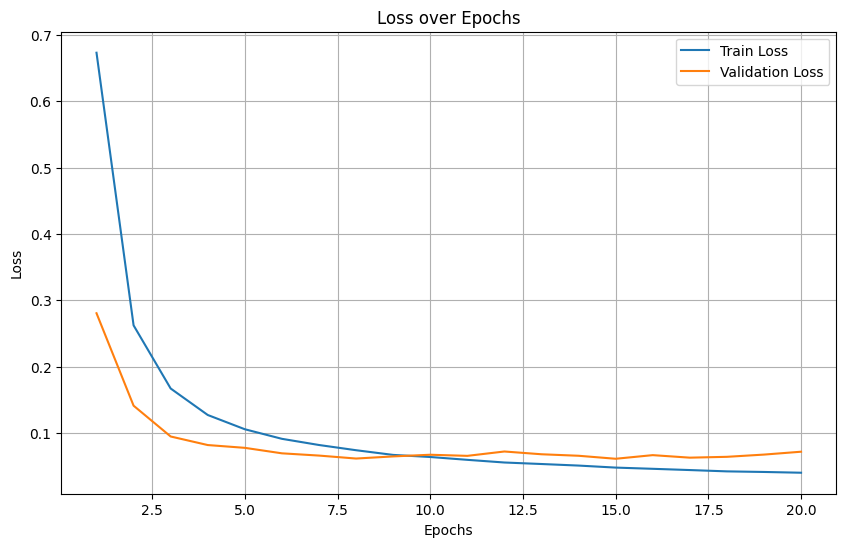

In [28]:
# Tracé des pertes
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
model_v3 = torch.load("model/model_full_v3.pth")
model_v3.eval()

C:\Users\Nasir\AppData\Local\Temp\ipykernel_19656\246385410.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_v3 = torch.load("model_full_v3.pth")


CaptchaModel(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_layers): ModuleList(
    (0-5): 6 x Sequential(
      (0): Linear(in_features=8928, out_features=64, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.5, inplace=False)
      (3): Linear(in_features=64, out_features=36, bias=True)
      (4): Sigmoid()
    )
  )
)

In [30]:
summary(model_v3, (1, 75, 250))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 16, 75, 250]         160
├─MaxPool2d: 1-2                         [-1, 16, 37, 125]         --
├─Conv2d: 1-3                            [-1, 32, 37, 125]         4,640
├─MaxPool2d: 1-4                         [-1, 32, 18, 62]          --
├─Conv2d: 1-5                            [-1, 32, 18, 62]          9,248
├─MaxPool2d: 1-6                         [-1, 32, 9, 31]           --
├─BatchNorm2d: 1-7                       [-1, 32, 9, 31]           64
├─ModuleList: 1                          []                        --
|    └─Sequential: 2-1                   [-1, 36]                  --
|    |    └─Linear: 3-1                  [-1, 64]                  571,456
|    |    └─ReLU: 3-2                    [-1, 64]                  --
|    |    └─Dropout: 3-3                 [-1, 64]                  --
|    |    └─Linear: 3-4                  [-1, 36]                  2,340


Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 16, 75, 250]         160
├─MaxPool2d: 1-2                         [-1, 16, 37, 125]         --
├─Conv2d: 1-3                            [-1, 32, 37, 125]         4,640
├─MaxPool2d: 1-4                         [-1, 32, 18, 62]          --
├─Conv2d: 1-5                            [-1, 32, 18, 62]          9,248
├─MaxPool2d: 1-6                         [-1, 32, 9, 31]           --
├─BatchNorm2d: 1-7                       [-1, 32, 9, 31]           64
├─ModuleList: 1                          []                        --
|    └─Sequential: 2-1                   [-1, 36]                  --
|    |    └─Linear: 3-1                  [-1, 64]                  571,456
|    |    └─ReLU: 3-2                    [-1, 64]                  --
|    |    └─Dropout: 3-3                 [-1, 64]                  --
|    |    └─Linear: 3-4                  [-1, 36]                  2,340


### Test the model on the test dataset

In [31]:
characters = string.ascii_uppercase + string.digits
model_v3.eval()
truepos = 0
count_img = 0
for images, labels in test_dataset:
    # print(images.shape)
    # print(labels.shape)
    # print(images)
    # print(model(images.unsqueeze(0)))
    prediction = predict_1(model_v3, images)
    labels = [characters[torch.argmax(la).item()] for la in labels]
    if sum(p == g for p, g in zip(prediction, labels)) != 6:
        count_img += 1
    #     print(prediction)
    #     print(labels)
    truepos += sum(p == g for p, g in zip(prediction, labels))
    

Accuracy = truepos/(len(test_dataset)*6)
Accuracy_v1 = (len(test_dataset)-count_img)/len(test_dataset)

### Result

In [32]:
print(f"l'accuracy sur les caractères est de {Accuracy}")
print(f"le nombre d'image qui ont au moins un caractère incorrect est de {count_img}") #count_img
print(f"l'autre accuracy sur les images est de {Accuracy_v1}") 

l'accuracy sur les caractères est de 0.9632183908045977
le nombre d'image qui ont au moins un caractère incorrect est de 1660
l'autre accuracy sur les images est de 0.8568965517241379
